# Przetwarzanie danych

Wczytujemy dane z pliku CSV, jawnie określając typy kolumn. Jeśli godzina w czasie odjazdu lub przyjazdu przekracza 24, jest przeliczana na pełne doby i konwertowana na format Timestamp.

In [4]:
import pandas as pd

def parse_extended_time(tstr):
    h, m, s = tstr.split(':')
    h, m, s = int(h), int(m), int(s)

    day_offset = h // 24
    hour_in_day = h % 24

    base_date = pd.Timestamp(year=2025, month=1, day=1)
    date_time = base_date + pd.Timedelta(days=day_offset, hours=hour_in_day, minutes=m, seconds=s)

    return date_time

# Wczytanie pliku CSV z jawnym określeniem typów
df = pd.read_csv(
    "connection_graph.csv",
    dtype={
        "id": "int64",
        "company": "string",
        "line": "string", 
        "start_stop": "string",
        "end_stop": "string",
        "start_stop_lat": "float64",
        "start_stop_lon": "float64",
        "end_stop_lat": "float64",
        "end_stop_lon": "float64"
    },
    low_memory=False 
)

# Konwersja czasów
df["departure_time"] = df["departure_time"].apply(parse_extended_time)
df["arrival_time"] = df["arrival_time"].apply(parse_extended_time)

# Sprawdzenie typów
print(df.dtypes)
print(df.head())

Unnamed: 0                 int64
company           string[python]
line              string[python]
departure_time    datetime64[ns]
arrival_time      datetime64[ns]
start_stop        string[python]
end_stop          string[python]
start_stop_lat           float64
start_stop_lon           float64
end_stop_lat             float64
end_stop_lon             float64
dtype: object
   Unnamed: 0       company line      departure_time        arrival_time  \
0           0  MPK Autobusy    A 2025-01-01 20:52:00 2025-01-01 20:53:00   
1           1  MPK Autobusy    A 2025-01-01 20:53:00 2025-01-01 20:54:00   
2           2  MPK Autobusy    A 2025-01-01 20:54:00 2025-01-01 20:55:00   
3           3  MPK Autobusy    A 2025-01-01 20:55:00 2025-01-01 20:57:00   
4           4  MPK Autobusy    A 2025-01-01 20:57:00 2025-01-01 20:59:00   

             start_stop              end_stop  start_stop_lat  start_stop_lon  \
0   Zajezdnia Obornicka              Paprotna       51.148737       17.021069   
1   

### Tworzenie klasy Connection i Stop

Definiujemy klasę Connection, która odpowiada za połączenie między przystankami, przechowując informacje o linii, punktach początkowym i końcowym oraz czasie podróży. Definiujemy także klasę Stop, reprezentującą przystanek z nazwą, współrzędnymi i listą dostępnych połączeń.

In [5]:


class Connection:
    def __init__(self, line, start, end, departure_time, arrival_time):
        self.line = line
        self.start: Stop = start 
        self.end: Stop = end  
        self.departure_time = departure_time
        self.arrival_time = arrival_time
        self.travel_time = (arrival_time - departure_time).total_seconds()
        
    def __repr__(self):
        return (f"Connection({self.line}, {self.start.name} -> {self.end.name}, "
                f"{self.departure_time.strftime('%H:%M:%S')} - {self.arrival_time.strftime('%H:%M:%S')})")


class Stop:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.connections: Connection = []

    def add_connection(self, connection):
        self.connections.append(connection)

    def __repr__(self):
        return f"Stop({self.name}, {self.lat}, {self.lon})"

### Tworzenie grafu 

Tworzymy graf, w którym węzłami są przystanki (obiektu Stop), a krawędziami połączenia (Connection) między nimi. Iterujemy przez df, dodając brakujące przystanki do stop_graph i tworząc połączenia z informacjami o linii, godzinach odjazdu i przyjazdu. 

In [6]:
stop_graph = {}
for _, row in df.iterrows():
    start_name = row["start_stop"]
    end_name = row["end_stop"]
    
    if start_name not in stop_graph:
        stop_graph[start_name] = Stop(start_name, row["start_stop_lat"], row["start_stop_lon"])
    if end_name not in stop_graph:
        stop_graph[end_name] = Stop(end_name, row["end_stop_lat"], row["end_stop_lon"])
    
    connection = Connection(
        line=row["line"],
        start=stop_graph[start_name],
        end=stop_graph[end_name],
        departure_time=row["departure_time"],
        arrival_time=row["arrival_time"]
    )
    
    stop_graph[start_name].add_connection(connection)


# Zad 1

## Zad1a - algorytm Dijkstry

Funkcja find_earliest_connection wyszukuje najwcześniejsze możliwe połączenie z listy dostępnych, uwzględniając czas przesiadki, jeśli zmienia się linia. Napisaliśmy algorytm Dijkstry zoptymalizowany pod kątem minimalizacji czasu podróży, wykorzystujący kolejkę priorytetową (heapq).

In [7]:
import heapq
import time
from datetime import datetime, timedelta

def find_earliest_connection(connections, current_time, previous_line=None, boarding_time=1):

    transfer_delta = timedelta(minutes=boarding_time)
    earliest = None
    for conn in connections:
        # Jeśli nie jeździmy tą samą linią, trzeba doliczyć czas transferu.
        required_departure = current_time if (previous_line is None or conn.line == previous_line) else current_time + transfer_delta
        if conn.departure_time >= required_departure:
            if earliest is None or conn.departure_time < earliest.departure_time:
                earliest = conn
    return earliest



class DijkstraRouter:
    def __init__(self, stop_graph):
        self.stop_graph = stop_graph

    def _validate_stops(self, start_stop, end_stop):
        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            print("ERROR: Przystanek startowy lub końcowy nie istnieje w grafie.")
            return False
        return True

    def _initialize_search_structures(self, start_stop, start_time):
        base_date = datetime(2025, 1, 1)
        start_datetime = base_date.replace(hour=start_time.hour, minute=start_time.minute, second=start_time.second)
        
        travel_times = {name: float('inf') for name in self.stop_graph}
        previous = {name: None for name in self.stop_graph}
        arrival_times = {name: None for name in self.stop_graph}
        previous_lines = {name: None for name in self.stop_graph}
        
        travel_times[start_stop] = 0
        arrival_times[start_stop] = start_datetime
        
        return travel_times, previous, arrival_times, previous_lines, start_datetime

    def _group_connections_by_destination(self, current_stop):
        grouped_connections = {}
        for conn in current_stop.connections:
            destination = conn.end.name
            if destination not in grouped_connections:
                grouped_connections[destination] = []
            grouped_connections[destination].append(conn)
        return grouped_connections

    def _reconstruct_route(self, previous, end_stop):
        route = []
        current = end_stop
        while current and previous[current]:
            prev_stop, conn = previous[current]
            route.append(conn)
            current = prev_stop
        route.reverse()
        return route

    def find_route(self, start_stop, end_stop, start_time, boarding_time=1):

        if not self._validate_stops(start_stop, end_stop):
            return None

        start_measure = time.time()

        # Inicjalizacja struktur wyszukiwania
        travel_times, previous, arrival_times, previous_lines, current_time = self._initialize_search_structures(start_stop, start_time)
        
        # Kolejka priorytetowa (open set) dla algorytmu Dijkstry
        open_set = [(0, start_stop)]
        # Zbiór odwiedzonych węzłów (closed set)
        closed_set = set()

        visited_edges = 0  # Licznik odwiedzonych krawędzi
        visited_nodes = 0  # Licznik odwiedzonych węzłów
        
        while open_set:
            current_travel_time, current_stop_name = heapq.heappop(open_set)
            
            # Jeśli przystanek już był przetwarzany, pomijamy go
            if current_stop_name in closed_set:
                continue
            
            # Dodajemy przystanek do zbioru zamkniętych
            closed_set.add(current_stop_name)
            visited_nodes += 1  # Zwiększ licznik odwiedzonych węzłów
            
            # Jeśli dotarliśmy do celu, przerywamy pętlę
            if current_stop_name == end_stop:
                break
            
            current_stop = self.stop_graph[current_stop_name]
            current_arrival_time = arrival_times[current_stop_name]
            current_line = previous_lines[current_stop_name]
            
            # Grupowanie połączeń wg przystanków docelowych
            grouped_connections = self._group_connections_by_destination(current_stop)
            
            for next_stop_name, conns in grouped_connections.items():
                # Znajdź najwcześniejsze połączenie z uwzględnieniem zasad przesiadek
                earliest_conn = find_earliest_connection(
                    conns, current_arrival_time, 
                    previous_line=current_line, 
                    boarding_time=boarding_time
                )
                
                if earliest_conn is None:
                    continue
                
                travel_time = (earliest_conn.arrival_time - current_arrival_time).total_seconds() / 60
                
                # Aktualizujemy tylko, jeśli znaleziono szybszą trasę
                if current_travel_time + travel_time < travel_times[next_stop_name]:
                    travel_times[next_stop_name] = current_travel_time + travel_time
                    previous[next_stop_name] = (current_stop_name, earliest_conn)
                    arrival_times[next_stop_name] = earliest_conn.arrival_time
                    previous_lines[next_stop_name] = earliest_conn.line
                    
                    heapq.heappush(open_set, (travel_times[next_stop_name], next_stop_name))
                    visited_edges += 1  # Zwiększ licznik odwiedzonych krawędzi
        
        end_measure = time.time()
          
        if travel_times[end_stop] == float('inf'):
            print("DEBUG: Brak dostępnej trasy!")
            return None
        
        # Rekonstrukcja trasy
        route = self._reconstruct_route(previous, end_stop)

        transfer_count = 0
        for i in range(1, len(route)):
            if route[i].line != route[i-1].line:
                transfer_count += 1
        

        
        return {
            'route': route,
            'total_cost': travel_times[end_stop],
            'calculation_time': end_measure - start_measure,
            'transfers': transfer_count,
            'visited_nodes': visited_nodes,
            'visited_edges': visited_edges
        }



Funkcje do wyswietlania wyników

In [8]:
# --- Użycie routera ---
def find_and_print_route(router, start_stop, end_stop, start_time_str):
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    result = router.find_route(start_stop, end_stop, start_time)
    
    if result:
        print("\nHarmonogram przejazdu:")
        for connection in result['route']:
            print(f"Linia: {connection.line}, "
                  f"Z: {connection.start.name} o {connection.departure_time.strftime('%H:%M:%S')}, "
                  f"Do: {connection.end.name} o {connection.arrival_time.strftime('%H:%M:%S')}")
        print(f"Liczba przesiadek: {result['transfers']}")
        print(f"\nKoszt trasy (min): {result['total_cost']}")
        print(f"Czas obliczeń: {result['calculation_time']:.4f} sekund")
    else:
        print("Nie znaleziono trasy.")


def find_and_print_simple_route(router, start_stop, end_stop, start_time_str):
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    result = router.find_route(start_stop, end_stop, start_time)
    
    if result:
        print("\n=== Przejazd od punktu A do B ===")
        print(f"Start: {start_stop}")
        print(f"Cel: {end_stop}\n")
        
        used_lines = {}  # Przechowuje linie i ich przystanki początkowe/końcowe
        for connection in result['route']:
            line = connection.line
            if line not in used_lines:
                used_lines[line] = {
                    "start": connection.start.name,
                    "departure_time": connection.departure_time.strftime('%H:%M:%S'),
                    "end": connection.end.name,
                    "arrival_time": connection.arrival_time.strftime('%H:%M:%S')
                }
            else:
                used_lines[line]["end"] = connection.end.name
                used_lines[line]["arrival_time"] = connection.arrival_time.strftime('%H:%M:%S')

        print("=== Harmonogram linii ===")
        for line, stops in used_lines.items():
            print(f"Linia {line}: {stops['start']} ({stops['departure_time']}) ➝ {stops['end']} ({stops['arrival_time']})")
        
        print("\nLiczba przesiadek:", result['transfers'])
        print(f"Koszt trasy: {result['total_cost']} min")
        print(f"Czas obliczeń: {result['calculation_time']:.4f} sek\n")
    else:
        print("Nie znaleziono trasy.")


router = DijkstraRouter(stop_graph)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")



=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ C.H. Korona (07:25:00)
Linia 131: C.H. Korona (07:26:00) ➝ Brücknera (07:27:00)
Linia 128 : Brücknera (07:29:00) ➝ KROMERA (07:35:00)
Linia 116 : KROMERA (07:36:00) ➝ Kasprowicza (07:39:00)
Linia 118: Kasprowicza (07:42:00) ➝ most Milenijny (07:55:00)
Linia 104: most Milenijny (07:56:00) ➝ Kwiska (08:02:00)
Linia 122: Kwiska (08:03:00) ➝ KUŹNIKI (08:12:00)
Linia 129: KUŹNIKI (08:14:00) ➝ Kołobrzeska (08:15:00)

Liczba przesiadek: 7
Koszt trasy: 75.0 min
Czas obliczeń: 1.6725 sek



## Algorytm A*

Stworzyliśmy funkcję AStarRouter, która implementuje algorytm A* do wyznaczania optymalnej trasy na podstawie czasu podróży. Klasa przyjmuje jako argument funkcję heurystyczną, która wpływa na wybór kolejnych przystanków w procesie wyszukiwania.

In [9]:
class AStarRouter:
    def __init__(self, stop_graph, heuristic_function):
        self.stop_graph = stop_graph
        self.heuristic = heuristic_function

    def _validate_stops(self, start_stop, end_stop):
        # Sprawdzenie, czy przystanki początkowy i końcowy istnieją w grafie
        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            print("ERROR: Przystanek startowy lub końcowy nie istnieje w grafie.")
            return False
        return True

    def _initialize_search_structures(self, start_stop, start_time):
        # Inicjalizacja struktur danych potrzebnych do wyszukiwania trasy
        base_date = datetime(2025, 1, 1)
        start_datetime = base_date.replace(hour=start_time.hour, minute=start_time.minute, second=start_time.second)
        
        travel_times = {name: float('inf') for name in self.stop_graph}
        previous = {name: None for name in self.stop_graph}
        arrival_times = {name: None for name in self.stop_graph}
        previous_lines = {name: None for name in self.stop_graph}
        
        travel_times[start_stop] = 0
        arrival_times[start_stop] = start_datetime
        
        return travel_times, previous, arrival_times, previous_lines, start_datetime

    def _group_connections_by_destination(self, current_stop):
        # Grupowanie połączeń według przystanków docelowych
        grouped_connections = {}
        for conn in current_stop.connections:
            destination = conn.end.name
            if destination not in grouped_connections:
                grouped_connections[destination] = []
            grouped_connections[destination].append(conn)
        return grouped_connections

    def _reconstruct_route(self, previous, end_stop):
        # Odtwarzanie trasy na podstawie poprzednich przystanków
        route = []
        current = end_stop
        while current and previous[current]:
            prev_stop, conn = previous[current]
            route.append(conn)
            current = prev_stop
        route.reverse()
        return route

    def find_route(self, start_stop, end_stop, start_time, boarding_time=1):
        # Główna metoda wyszukiwania trasy
        if not self._validate_stops(start_stop, end_stop):
            return None

        start_measure = time.time()
        
        travel_times, previous, arrival_times, previous_lines, current_time = self._initialize_search_structures(start_stop, start_time)
        
        open_set = [(0, 0, start_stop)]
        closed_set = set()
        
        visited_edges = 0  # Licznik odwiedzonych krawędzi
        visited_nodes = 0  # Licznik odwiedzonych węzłów

        while open_set:
            current_f, current_g, current_stop_name = heapq.heappop(open_set)
            
            if current_stop_name in closed_set:
                continue
            
            closed_set.add(current_stop_name)
            visited_nodes += 1  # Zwiększ licznik odwiedzonych węzłów
            
            if current_stop_name == end_stop:
                break
            
            current_stop = self.stop_graph[current_stop_name]
            current_arrival_time = arrival_times[current_stop_name]
            current_line = previous_lines[current_stop_name]
            
            grouped_connections = self._group_connections_by_destination(current_stop)
            
            for next_stop_name, conns in grouped_connections.items():
                if next_stop_name in closed_set:
                    continue
                
                # Znajdź najwcześniejsze połączenie
                earliest_conn = find_earliest_connection(conns, current_arrival_time, previous_line=current_line, boarding_time=boarding_time)
                
                if earliest_conn is None:
                    continue
                
                travel_time = (earliest_conn.arrival_time - current_arrival_time).total_seconds() / 60

                heuristic_args = {
                    'current_line': current_line,
                    'next_line': earliest_conn.line,
                    'current_stop': current_stop,
                    'next_stop': self.stop_graph[next_stop_name],
                    'end_stop': self.stop_graph[end_stop],
                    'current_time': current_arrival_time,
                    'start_time': start_time
                }
                heuristic = self.heuristic(**heuristic_args)
                
                new_g = current_g + travel_time
                h_cost = heuristic
                f_cost = new_g + h_cost
                
                if new_g < travel_times[next_stop_name]:
                    travel_times[next_stop_name] = new_g
                    previous[next_stop_name] = (current_stop_name, earliest_conn)
                    arrival_times[next_stop_name] = earliest_conn.arrival_time
                    previous_lines[next_stop_name] = earliest_conn.line
                    
                    heapq.heappush(open_set, (f_cost, new_g, next_stop_name))
                    visited_edges += 1  # Zwiększ licznik odwiedzonych krawędzi
        
        end_measure = time.time()
        
        if travel_times[end_stop] == float('inf'):
            print("DEBUG: Brak dostępnej trasy!")
            return None
        
        route = self._reconstruct_route(previous, end_stop)

        transfer_count = 0
        for i in range(1, len(route)):
            if route[i].line != route[i-1].line:
                transfer_count += 1
        
        # Zwróć szczegóły trasy
        return {
            'route': route,
            'total_cost': travel_times[end_stop],
            'calculation_time': end_measure - start_measure,
            'transfers': transfer_count,
            'visited_nodes': visited_nodes,
            'visited_edges': visited_edges
        }

## Zad1b - Algorytm A* w oparciu o czas przejazdu
Uywamy algorytmy A* z funkcja heurystyczna, która oblicza czas przejazdu na podstawie odległości między przystankami. Jej argumentem jest m.in średnia prędkość która zakładamy, ze wynosi 20km/h.
Funkcja haversine_distance oblicza odległość geograficzną między dwoma punktami na podstawie ich współrzędnych.

In [10]:
from math import radians, sin, cos, sqrt, atan2, degrees

def haversine_distance(lat1, lon1, lat2, lon2):
    # Obliczanie odległości geograficznej między dwoma punktami na podstawie współrzędnych
    R = 6371.0  # Średnia promień Ziemi w km

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


def time_penalty_function(speed=25, **kwargs):
    # Funkcja heurystyczna obliczająca karę czasową na podstawie odległości i prędkości
    current_stop = kwargs['current_stop']
    end_stop = kwargs['end_stop']
    
    distance = haversine_distance(current_stop.lat, current_stop.lon, end_stop.lat, end_stop.lon)
    
    if distance == 0:
        return 0
    
    time_penalty = distance / speed
    return time_penalty

# Tworzenie routera A* z funkcją heurystyczną opartą na czasie przejazdu
router = AStarRouter(stop_graph, time_penalty_function)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")




=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ C.H. Korona (07:25:00)
Linia 131: C.H. Korona (07:26:00) ➝ Brücknera (07:27:00)
Linia 128 : Brücknera (07:29:00) ➝ KROMERA (07:35:00)
Linia 116 : KROMERA (07:36:00) ➝ Kasprowicza (07:39:00)
Linia 118: Kasprowicza (07:42:00) ➝ most Milenijny (07:55:00)
Linia 104: most Milenijny (07:56:00) ➝ Kwiska (08:02:00)
Linia 122: Kwiska (08:03:00) ➝ KUŹNIKI (08:12:00)
Linia 129: KUŹNIKI (08:14:00) ➝ Kołobrzeska (08:15:00)

Liczba przesiadek: 7
Koszt trasy: 75.0 min
Czas obliczeń: 0.9525 sek



## Zad1c - Algorytm A* w oparciu o kryterium przesiadek

Używamy algorytmu A* z funkcją heurystyczną, która uwzględnia karę za przesiadkę. Wielkość tej kary możemy modyfikować, zmieniając parametr transfer_penalty w funkcji transfer_penalty_function, która dodaje karę, jeśli zmienia się linia.

In [ ]:

def get_connections_by_line(connections, current_time, current_line, boarding_time):
    same_line_connections = []
    different_line_connections = []
    
    for conn in connections:
        if conn.departure_time < current_time:
            continue
            
        if current_line and conn.line == current_line:
            same_line_connections.append(conn)
        else:
            # Dla różnych linii sprawdź, czy spełnia wymagania dotyczące czasu przesiadki
            if current_line is None or conn.departure_time >= current_time + timedelta(minutes=boarding_time):
                different_line_connections.append(conn)
    
    return same_line_connections, different_line_connections


class AstarRouterForTransfers(AStarRouter):
    def __init__(self, stop_graph, heuristic_function):
        super().__init__(stop_graph, heuristic_function)

    def _validate_stops(self, start_stop, end_stop):
        if start_stop not in self.stop_graph or end_stop not in self.stop_graph:
            print("ERROR: Przystanek startowy lub końcowy nie istnieje w grafie.")
            return False
        return True

    def _initialize_search_structures(self, start_stop, start_time):
        base_date = datetime(2025, 1, 1)
        start_datetime = base_date.replace(hour=start_time.hour, minute=start_time.minute, second=start_time.second)
        
        travel_times = {(name, None): float('inf') for name in self.stop_graph}
        previous = {(name, None): None for name in self.stop_graph}
        arrival_times = {(name, None): None for name in self.stop_graph}
        transfer_counts = {(name, None): float('inf') for name in self.stop_graph}
        
        travel_times[(start_stop, None)] = 0
        arrival_times[(start_stop, None)] = start_datetime
        transfer_counts[(start_stop, None)] = 0
        
        return travel_times, previous, arrival_times, transfer_counts, start_datetime

    def _group_connections_by_destination(self, current_stop):
        grouped_connections = {}
        for conn in current_stop.connections:
            destination = conn.end.name
            if destination not in grouped_connections:
                grouped_connections[destination] = []
            grouped_connections[destination].append(conn)
        return grouped_connections

    def _reconstruct_route(self, previous, end_stop, end_line):
        route = []
        current_key = (end_stop, end_line)
        while current_key and previous[current_key]:
            prev_key, conn = previous[current_key]
            route.append(conn)
            current_key = prev_key
        route.reverse()
        return route

    def _get_best_end_key(self, end_stop, transfer_counts):
        best_key = None
        min_transfers = float('inf')
        
        for key, count in transfer_counts.items():
            if key[0] == end_stop and count < min_transfers:
                min_transfers = count
                best_key = key
                
        return best_key, min_transfers

    def find_route(self, start_stop, end_stop, start_time, boarding_time=1):
        if not self._validate_stops(start_stop, end_stop):
            return None

        start_measure = time.time()
        
        # Konwertuj czas w formacie tekstowym na datetime, jeśli to konieczne
        if isinstance(start_time, str):
            base_date = datetime(2025, 1, 1)
            time_obj = datetime.strptime(start_time, "%H:%M:%S")
            start_time = base_date.replace(hour=time_obj.hour, minute=time_obj.minute, second=time_obj.second)
        
        # Inicjalizuj struktury danych
        travel_times, previous, arrival_times, transfer_counts, start_datetime = self._initialize_search_structures(start_stop, start_time)
        
        # Kolejka priorytetowa (f_score, transfer_count, entry_id, stop_name, line)
        entry_count = 0  # Unikalny identyfikator dla elementów kolejki
        open_set = [(0, 0, entry_count, start_stop, None)]
        closed_set = set()
        
        visited_edges = 0
        visited_nodes = 0
        
        while open_set:
            _, current_transfers, _, current_stop_name, current_line = heapq.heappop(open_set)
            current_key = (current_stop_name, current_line)
            
            # Pomiń, jeśli już przetworzono tę kombinację przystanku i linii
            if current_key in closed_set:
                continue
            
            closed_set.add(current_key)
            visited_nodes += 1
            
            # Nie zatrzymuj się na celu - kontynuuj, aby znaleźć trasę z minimalną liczbą przesiadek
            current_stop = self.stop_graph[current_stop_name]
            current_arrival_time = arrival_times[current_key]
            
            # Pobierz wszystkie połączenia pogrupowane według celu
            grouped_connections = self._group_connections_by_destination(current_stop)
            
            for next_stop_name, connections in grouped_connections.items():
                visited_edges += 1
                
                # Oddziel połączenia według linii (ta sama lub różna)
                same_line_conns, diff_line_conns = get_connections_by_line(
                    connections, current_arrival_time, current_line, boarding_time
                )
                
                # Najpierw przetwarzaj połączenia na tej samej linii (bez kary za przesiadkę)
                for conn in sorted(same_line_conns, key=lambda x: x.departure_time):
                    # Bez zwiększania liczby przesiadek
                    new_transfers = current_transfers
                    travel_time = (conn.arrival_time - current_arrival_time).total_seconds() / 60
                    new_key = (next_stop_name, conn.line)
                    
                    if new_key not in transfer_counts or new_transfers < transfer_counts[new_key]:
                        transfer_counts[new_key] = new_transfers
                        travel_times[new_key] = travel_times[current_key] + travel_time
                        arrival_times[new_key] = conn.arrival_time
                        previous[new_key] = (current_key, conn)
                        
                        # Oblicz heurystykę
                        heuristic_args = {
                            'current_line': current_line,
                            'next_line': conn.line, 
                            'current_stop': current_stop,
                            'next_stop': self.stop_graph[next_stop_name],
                            'end_stop': self.stop_graph[end_stop],
                            'current_time': current_arrival_time,
                            'start_time': start_time
                        }
                        h_cost = self.heuristic(**heuristic_args)
                        
                        f_cost = travel_times[new_key] + h_cost
                        entry_count += 1
                        heapq.heappush(open_set, (f_cost, new_transfers, entry_count, next_stop_name, conn.line))
                
                # Następnie przetwarzaj połączenia na różnych liniach (z karą za przesiadkę)
                for conn in sorted(diff_line_conns, key=lambda x: x.departure_time):
                    # Zwiększ liczbę przesiadek
                    new_transfers = current_transfers + (1 if current_line is not None else 0)
                    travel_time = (conn.arrival_time - current_arrival_time).total_seconds() / 60
                    
                    if current_line is not None and conn.line != current_line:
                        # Dodaj czas wsiadania do czasu podróży
                        travel_time += boarding_time
                    
                    new_key = (next_stop_name, conn.line)
                    
                    if new_key not in transfer_counts or new_transfers < transfer_counts[new_key]:
                        transfer_counts[new_key] = new_transfers
                        travel_times[new_key] = travel_times[current_key] + travel_time
                        arrival_times[new_key] = conn.arrival_time
                        previous[new_key] = (current_key, conn)
                        
                        # Oblicz heurystykę
                        heuristic_args = {
                            'current_line': current_line,
                            'next_line': conn.line,
                            'current_stop': current_stop, 
                            'next_stop': self.stop_graph[next_stop_name],
                            'end_stop': self.stop_graph[end_stop],
                            'current_time': current_arrival_time,
                            'start_time': start_time
                        }
                        h_cost = self.heuristic(**heuristic_args)
                        
                        f_cost = travel_times[new_key] + h_cost
                        entry_count += 1
                        heapq.heappush(open_set, (f_cost, new_transfers, entry_count, next_stop_name, conn.line))
        
        end_measure = time.time()
        
        # Znajdź najlepszą trasę do celu (z minimalną liczbą przesiadek)
        best_key, min_transfers = self._get_best_end_key(end_stop, transfer_counts)
        
        if best_key is None or min_transfers == float('inf'):
            print("DEBUG: Brak dostępnej trasy!")
            return None
        
        # Odtwórz trasę
        route = self._reconstruct_route(previous, end_stop, best_key[1])
        
        return {
            'route': route,
            'total_cost': travel_times[best_key],
            'calculation_time': end_measure - start_measure,
            'transfers': min_transfers,
            'visited_nodes': visited_nodes,
            'visited_edges': visited_edges
        }


def transfer_penalty_function(transfer_penalty = 30, **kwargs):
    current_line = kwargs['current_line']
    next_line = kwargs['next_line']

    if current_line and current_line != next_line:
        return transfer_penalty
    return 0


router = AstarRouterForTransfers(
    stop_graph, 
    heuristic_function = transfer_penalty_function
)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")


=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ PL. GRUNWALDZKI (07:38:00)
Linia 149: PL. GRUNWALDZKI (07:44:00) ➝ Kołobrzeska (08:17:00)

Liczba przesiadek: 1
Koszt trasy: 78.0 min
Czas obliczeń: 25.5702 sek



## Zad1d - optymalizacja algorytmu A*

Robimy funkcje, które wprowadzają kary za odległość i zmianę kierunku w algorytmie A*. distance_penalty_function dodaje karę za odległość, a direction_penalty_function sprawdza, czy zmienił się kierunek podróży, nakładając karę, jeśli różnica w kierunku przekroczy określony próg. Funkcja hybrid_penalty_function sumuje obie kary, łącząc je w jedną wartość.

In [12]:

def distance_penalty_function(distance_penalty = 4, **kwargs):
    current_stop = kwargs['current_stop']
    end_stop = kwargs['end_stop']
    distance = haversine_distance(current_stop.lat, current_stop.lon, end_stop.lat, end_stop.lon)
    if distance == 0: 
        return 0
    return distance_penalty * distance



import math

def direction_penalty_function(direction_penalty=15, max_angle_degrees=60, **kwargs):
    current_stop = kwargs['current_stop']
    next_stop = kwargs['next_stop']
    end_stop = kwargs['end_stop']
    
    # Pobierz współrzędne
    current_lat, current_lon = current_stop.lat, current_stop.lon
    next_lat, next_lon = next_stop.lat, next_stop.lon
    end_lat, end_lon = end_stop.lat, end_stop.lon
    
    # Oblicz wektory
    # Wektor od obecnego przystanku do końcowego
    vector_to_end = (end_lat - current_lat, end_lon - current_lon)
    # Wektor od obecnego przystanku do następnego
    vector_to_next = (next_lat - current_lat, next_lon - current_lon)
    
    # Oblicz długości wektorów
    magnitude_to_end = math.sqrt(vector_to_end[0]**2 + vector_to_end[1]**2)
    magnitude_to_next = math.sqrt(vector_to_next[0]**2 + vector_to_next[1]**2)
    
    # Obsłuż przypadek, gdy przystanki znajdują się w tej samej lokalizacji (uniknięcie dzielenia przez zero)
    if magnitude_to_end < 1e-10 or magnitude_to_next < 1e-10:
        return 0
    
    # Oblicz iloczyn skalarny
    dot_product = vector_to_end[0] * vector_to_next[0] + vector_to_end[1] * vector_to_next[1]
    
    # Oblicz kąt w radianach, a następnie przelicz na stopnie
    # cos(kąt) = iloczyn skalarny / (długość1 * długość2)
    cos_angle = dot_product / (magnitude_to_end * magnitude_to_next)
    # Ogranicz wartość do przedziału [-1,1], aby obsłużyć błędy zaokrągleń
    cos_angle = max(-1, min(1, cos_angle))
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)
    
    # Zastosuj karę, jeśli kąt jest większy niż max_angle_degrees
    if angle_deg > max_angle_degrees:
        return direction_penalty
    return 0



def hybrid_penalty_function(**kwargs):
    distance_penalty = distance_penalty_function(**kwargs)
    direction_penalty = direction_penalty_function(**kwargs)
    
    return distance_penalty + direction_penalty

router = AStarRouter(stop_graph, heuristic_function=hybrid_penalty_function)
find_and_print_simple_route(router, "Wilczyce - Sosnowa", "Kołobrzeska", "7:00:00")



=== Przejazd od punktu A do B ===
Start: Wilczyce - Sosnowa
Cel: Kołobrzeska

=== Harmonogram linii ===
Linia 911: Wilczyce - Sosnowa (07:10:00) ➝ C.H. Korona (07:25:00)
Linia 131: C.H. Korona (07:26:00) ➝ Brücknera (07:27:00)
Linia 128 : Brücknera (07:29:00) ➝ KROMERA (07:35:00)
Linia 116 : KROMERA (07:36:00) ➝ Kasprowicza (07:39:00)
Linia 118: Kasprowicza (07:42:00) ➝ most Milenijny (07:55:00)
Linia 104: most Milenijny (07:56:00) ➝ Milenijna (Hala Orbita) (07:57:00)
Linia 134: Milenijna (Hala Orbita) (08:02:00) ➝ Na Ostatnim Groszu (08:06:00)
Linia 129: Na Ostatnim Groszu (08:07:00) ➝ Kołobrzeska (08:15:00)

Liczba przesiadek: 7
Koszt trasy: 75.0 min
Czas obliczeń: 0.2099 sek



## Porównanie wydajności algorytmów dla różnych długości tras
Na koniec porównujemy wydajność algorytmu Dijkstry i A* w różnych scenariuszach, aby ocenić, który z nich jest bardziej efektywny w kontekście wyszukiwania najkrótszej trasy i ilosci przesiadek.

In [18]:
import pandas as pd
import time
from datetime import datetime

# Definiowanie tras
routes = {
    'short_route': ['PL. GRUNWALDZKI', 'PL. JANA PAWŁA II'],
    'medium_route': ['C.H. Korona', 'Husarska'],
    'long_route': ['Wilczyce - Sosnowa', 'Kołobrzeska']
}


# Funkcja do uruchamiania algorytmu i zbierania wyników
def get_algorithm_results(router, route, start_time_str):
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    result = router.find_route(route[0], route[1], start_time)
    
    if result:
        total_cost = result['total_cost']
        calculation_time = result['calculation_time']
        
        # Sprawdzenie czy total_cost i calculation_time są liczbami przed zaokrągleniem
        if isinstance(total_cost, (int, float)):
            total_cost = round(total_cost, 4)
        if isinstance(calculation_time, (int, float)):
            calculation_time = round(calculation_time, 4)
        
        return {
            'total_cost': total_cost,
            'calculation_time': calculation_time,
            'transfers': result['transfers']
        }
    else:
        return {
            'total_cost': 'Brak trasy',
            'calculation_time': 'Brak trasy',
            'transfers': 'Brak trasy'
        }

# Przygotowanie tabeli
results = []

# Testowanie algorytmu Dijkstry
for route_name, route in routes.items():
    router = DijkstraRouter(stop_graph)  
    result = get_algorithm_results(router, route, "07:00:00")
    result['algorithm'] = "Dijkstra"
    result['route_name'] = route_name
    results.append(result)

for route_name, route in routes.items():
    router = AstarRouterForTransfers(stop_graph, transfer_penalty_function)
    result = get_algorithm_results(router, route, "07:00:00")
    result['algorithm'] = "A Star For Transfer"
    result['route_name'] = route_name
    results.append(result)

heuristic_functions = [
    transfer_penalty_function,
    time_penalty_function,
    direction_penalty_function,
    distance_penalty_function,
    hybrid_penalty_function, #distance + direction
]

# Testowanie algorytmu A*
for route_name, route in routes.items():
    for heuristic_function in heuristic_functions:
        algorithm = f"A* {heuristic_function.__name__}"  # Tworzymy nazwę algorytmu z nazwy funkcji heurystycznej
        router = AStarRouter(stop_graph, heuristic_function)  # Router A* z odpowiednią heurystyką
        result = get_algorithm_results(router, route, "07:00:00")
        result['algorithm'] = algorithm
        result['route_name'] = route_name
        results.append(result)

# Tworzenie DataFrame z wyników
df = pd.DataFrame(results)

# Filtrowanie po trasach
short_route_df = df[df['route_name'] == 'short_route']
medium_route_df = df[df['route_name'] == 'medium_route']
long_route_df = df[df['route_name'] == 'long_route']

# Wyświetlanie wyników osobno dla każdej trasy
print("Short Route Results:")
print(short_route_df.to_string(index=False))

print("\nMedium Route Results:")
print(medium_route_df.to_string(index=False))

print("\nLong Route Results:")
print(long_route_df.to_string(index=False))


KeyboardInterrupt: 

## Generowanie losowych tras
Generujemy 20 losowych tras i wyznaczamy dla nich najkrótsze trasy, porównując wyniki algorytmów i liczymy statystyki dotyczące m.in czasu przejazdu, liczby przesiadek i długości trasy.

In [16]:
import random

def generate_test_cases(stop_graph, num_cases=50):
    stop_names = list(stop_graph.keys())
    test_cases = []
    
    # Czasy startu (rano, południe, wieczór)
    start_times = ["07:00:00", "12:00:00", "18:00:00"]
    
    for _ in range(num_cases):
        # Wybierz losowy przystanek początkowy i końcowy (różne od siebie)
        start_stop = random.choice(stop_names)
        end_stop = random.choice([s for s in stop_names if s != start_stop])
        
        # Wybierz losowy czas startu
        start_time = random.choice(start_times)
        
        test_cases.append((start_stop, end_stop, start_time))
    
    return test_cases

def compare_algorithms(stop_graph, test_cases):
    results = []
    
    # Heurystyki dla A*
    heuristic_functions = [
        transfer_penalty_function,
        time_penalty_function,
        distance_penalty_function,
        direction_penalty_function,
        hybrid_penalty_function # distance + direction
    ]
    
    # Dla każdego przypadku testowego
    for i, (start_stop, end_stop, start_time_str) in enumerate(test_cases):
        test_id = f"Test {i+1}: {start_stop} -> {end_stop} ({start_time_str})"
        print(f"Uruchamianie {test_id}...")
        
        # Parsowanie czasu startu
        start_time = datetime.strptime(start_time_str, "%H:%M:%S")
        
        # Testujemy algorytm Dijkstry
        router = DijkstraRouter(stop_graph)
        result = router.find_route(start_stop, end_stop, start_time)
        
        if result:
            # Zbieramy metryki
            results.append({
                'test_id': test_id,
                'algorithm': 'Dijkstra',
                'total_cost': result['total_cost'],
                'calculation_time': round(result['calculation_time'], 4),
                'transfers': result['transfers'],
                'visited_nodes': result.get('visited_nodes', 'N/A'),
                'visited_edges': result.get('visited_edges', 'N/A'),
                'route_length': len(result['route'])
            })
        else:
            print(f"Nie znaleziono trasy dla {test_id} używając Dijkstry")

        
        router = AstarRouterForTransfers(stop_graph, transfer_penalty_function)
        result = router.find_route(start_stop, end_stop, start_time)

        if result:
            # Zbieramy metryki
            results.append({
                'test_id': test_id,
                'algorithm': 'A* For Transfer',
                'total_cost': result['total_cost'],
                'calculation_time': round(result['calculation_time'], 4),
                'transfers': result['transfers'],
                'visited_nodes': result.get('visited_nodes', 'N/A'),
                'visited_edges': result.get('visited_edges', 'N/A'),
                'route_length': len(result['route'])
            })
        
        # Testujemy A* z różnymi heurystykami
        for heuristic_function in heuristic_functions:
            heuristic_name = heuristic_function.__name__
            router = AStarRouter(stop_graph, lambda **kwargs: heuristic_function(transfer_penalty=20, **kwargs))
            
            result = router.find_route(start_stop, end_stop, start_time)
            
            if result:
                # Zbieramy metryki
                results.append({
                    'test_id': test_id,
                    'algorithm': f'A*_{heuristic_name}',
                    'total_cost': result['total_cost'],
                    'calculation_time': round(result['calculation_time'], 4),
                    'transfers': result['transfers'],
                    'visited_nodes': result.get('visited_nodes', 'N/A'),
                    'visited_edges': result.get('visited_edges', 'N/A'),
                    'route_length': len(result['route'])
                })
            else:
                print(f"Nie znaleziono trasy dla {test_id} używając A* z {heuristic_name}")
    
    # Tworzymy DataFrame z wynikami
    df = pd.DataFrame(results)
    
    # Wyświetlamy średnie wyniki dla każdego algorytmu
    print("\nŚrednie wyniki dla algorytmów:")
    avg_results = df.groupby('algorithm').agg({
        'total_cost': 'mean',
        'calculation_time': 'mean',
        'transfers': 'mean',
        'visited_nodes': lambda x: x.mean(),
        'visited_edges': lambda x: x.mean()
    }).reset_index()
    
    print(avg_results.to_string(index=False))
    
    return df

# Przykład użycia:
test_cases = generate_test_cases(stop_graph, num_cases=20)
results_df = compare_algorithms(stop_graph, test_cases)

Uruchamianie Test 1: Psie Pole -> Poprzeczna (07:00:00)...
Uruchamianie Test 2: Spółdzielcza -> Czajkowskiego (12:00:00)...
Uruchamianie Test 3: Zbożowa -> Kępińska (18:00:00)...
Uruchamianie Test 4: KOZANÓW (Dokerska) -> Samotwór - Leśna (07:00:00)...
Uruchamianie Test 5: Pietrzykowice - Sportowa/Główna -> Jarzębinowa (07:00:00)...
Uruchamianie Test 6: Karłowicza -> Nowy Dom (18:00:00)...
Uruchamianie Test 7: Domaszczyn - Trzebnicka -> Długołęka - Parkowa skrzy. Konopnicka (18:00:00)...
Uruchamianie Test 8: Bielany Wrocławskie - Kościół -> Zakrzowska (07:00:00)...
Uruchamianie Test 9: DWORZEC NADODRZE -> Hartmana (07:00:00)...
Uruchamianie Test 10: Kominiarska (plac sportowy) -> Topolowa (18:00:00)...
Uruchamianie Test 11: Bulwar Dedala -> Mosty Pomorskie (18:00:00)...
Uruchamianie Test 12: Dobroszów - skrzy. Węgierska -> Ćwiczebna (12:00:00)...
Uruchamianie Test 13: Berenta -> Smolec - Lipowa/pętla (18:00:00)...
Uruchamianie Test 14: Pisarzowice - Kolejowa -> Brzezinka Średzka - ul. 

### Wykresy wyników

/var/folders/69/3bgwy7vx3g9g3hc8fwyj9pfh0000gn/T/ipykernel_24653/2766573798.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='algorithm', y='transfers', data=df, palette="pastel")


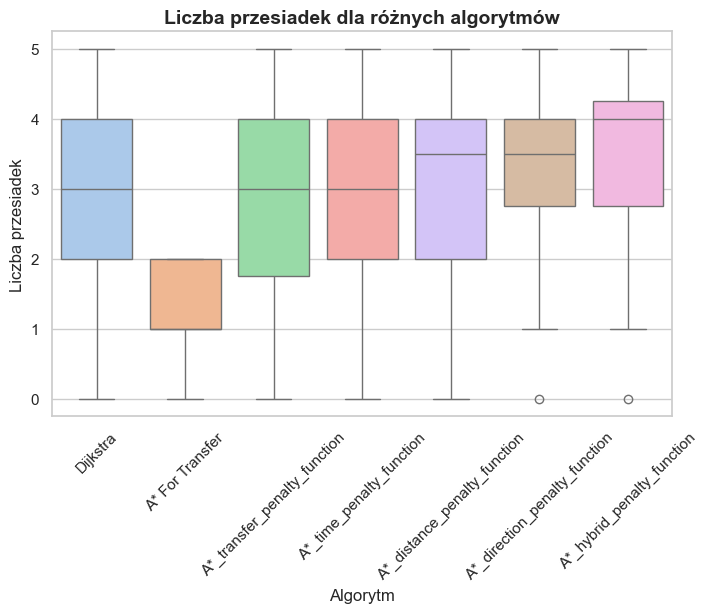

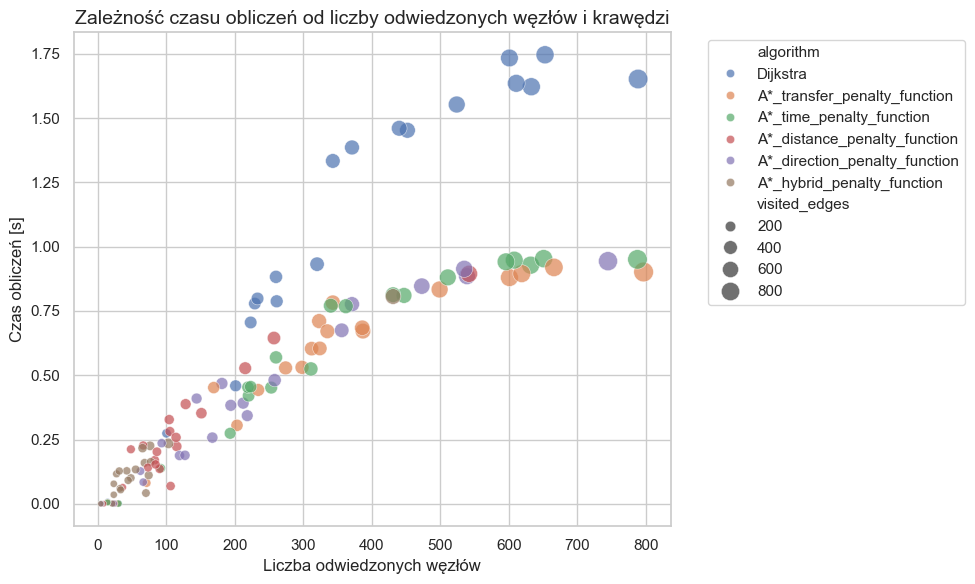

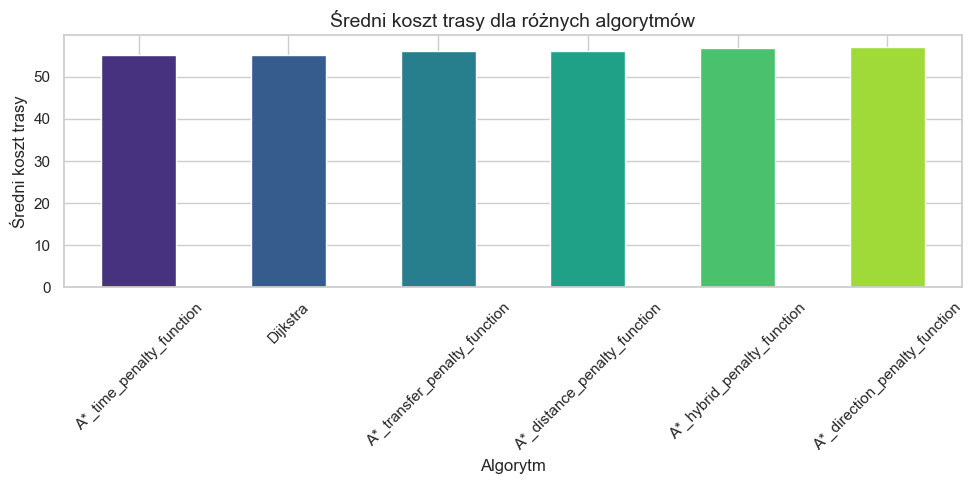

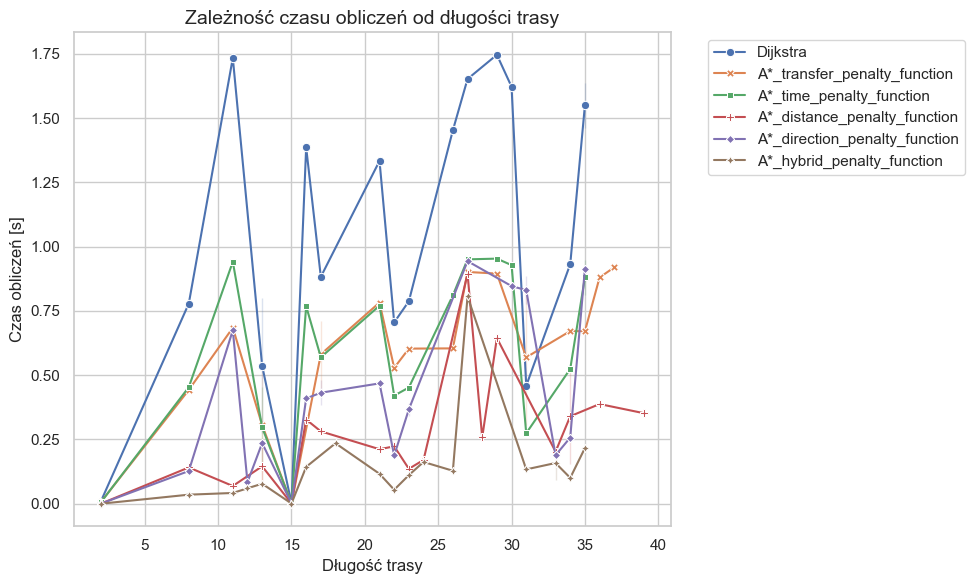

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


df = results_df
# Ustawienia stylu wykresów
sns.set_theme(style="whitegrid")

# Box plot liczby przesiadek 
plt.figure(figsize=(8, 5))
sns.boxplot(x='algorithm', y='transfers', data=df, palette="pastel")
plt.xticks(rotation=45)
plt.title('Liczba przesiadek dla różnych algorytmów', fontsize=14, fontweight='bold')
plt.xlabel('Algorytm', fontsize=12)
plt.ylabel('Liczba przesiadek', fontsize=12)
plt.show()


df_filtered = df[df['algorithm'] != 'A* For Transfer']

# Wykres sieciowy pokazujący zależność między odwiedzonymi węzłami a czasem obliczeń
plt.figure(figsize=(10, 6))
sns.scatterplot(x='visited_nodes', y='calculation_time', hue='algorithm', 
                size='visited_edges', sizes=(20, 200), alpha=0.7, data=df_filtered)
plt.title('Zależność czasu obliczeń od liczby odwiedzonych węzłów i krawędzi', fontsize=14)
plt.xlabel('Liczba odwiedzonych węzłów', fontsize=12)
plt.ylabel('Czas obliczeń [s]', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Wykres średnich kosztów tras dla każdego algorytmu
plt.figure(figsize=(10, 5))
avg_costs =  df_filtered.groupby('algorithm')['total_cost'].mean().sort_values()
avg_costs.plot(kind='bar', color=sns.color_palette("viridis", len(avg_costs)))
plt.title('Średni koszt trasy dla różnych algorytmów', fontsize=14)
plt.xlabel('Algorytm', fontsize=12)
plt.ylabel('Średni koszt trasy', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Wykres pokazujący jak czas obliczeń rośnie z długością znalezionej trasy
plt.figure(figsize=(10, 6))
sns.lineplot(x='route_length', y='calculation_time', hue='algorithm', 
             style='algorithm', markers=True, dashes=False, data=df_filtered)
plt.title('Zależność czasu obliczeń od długości trasy', fontsize=14)
plt.xlabel('Długość trasy', fontsize=12)
plt.ylabel('Czas obliczeń [s]', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Wizualizacja trasy
Uywamy networkx do wizualizacji grafu przystanków i połączeń. Używamy matplotlib do rysowania grafu, gdzie węzły reprezentują przystanki, a krawędzie połączenia między nimi. Węzły są oznaczone kolorami odpowiadającymi liniom, a etykiety wskazują nazwy przystanków.

Wykres zapisany do pliku: optymalna_trasa.png


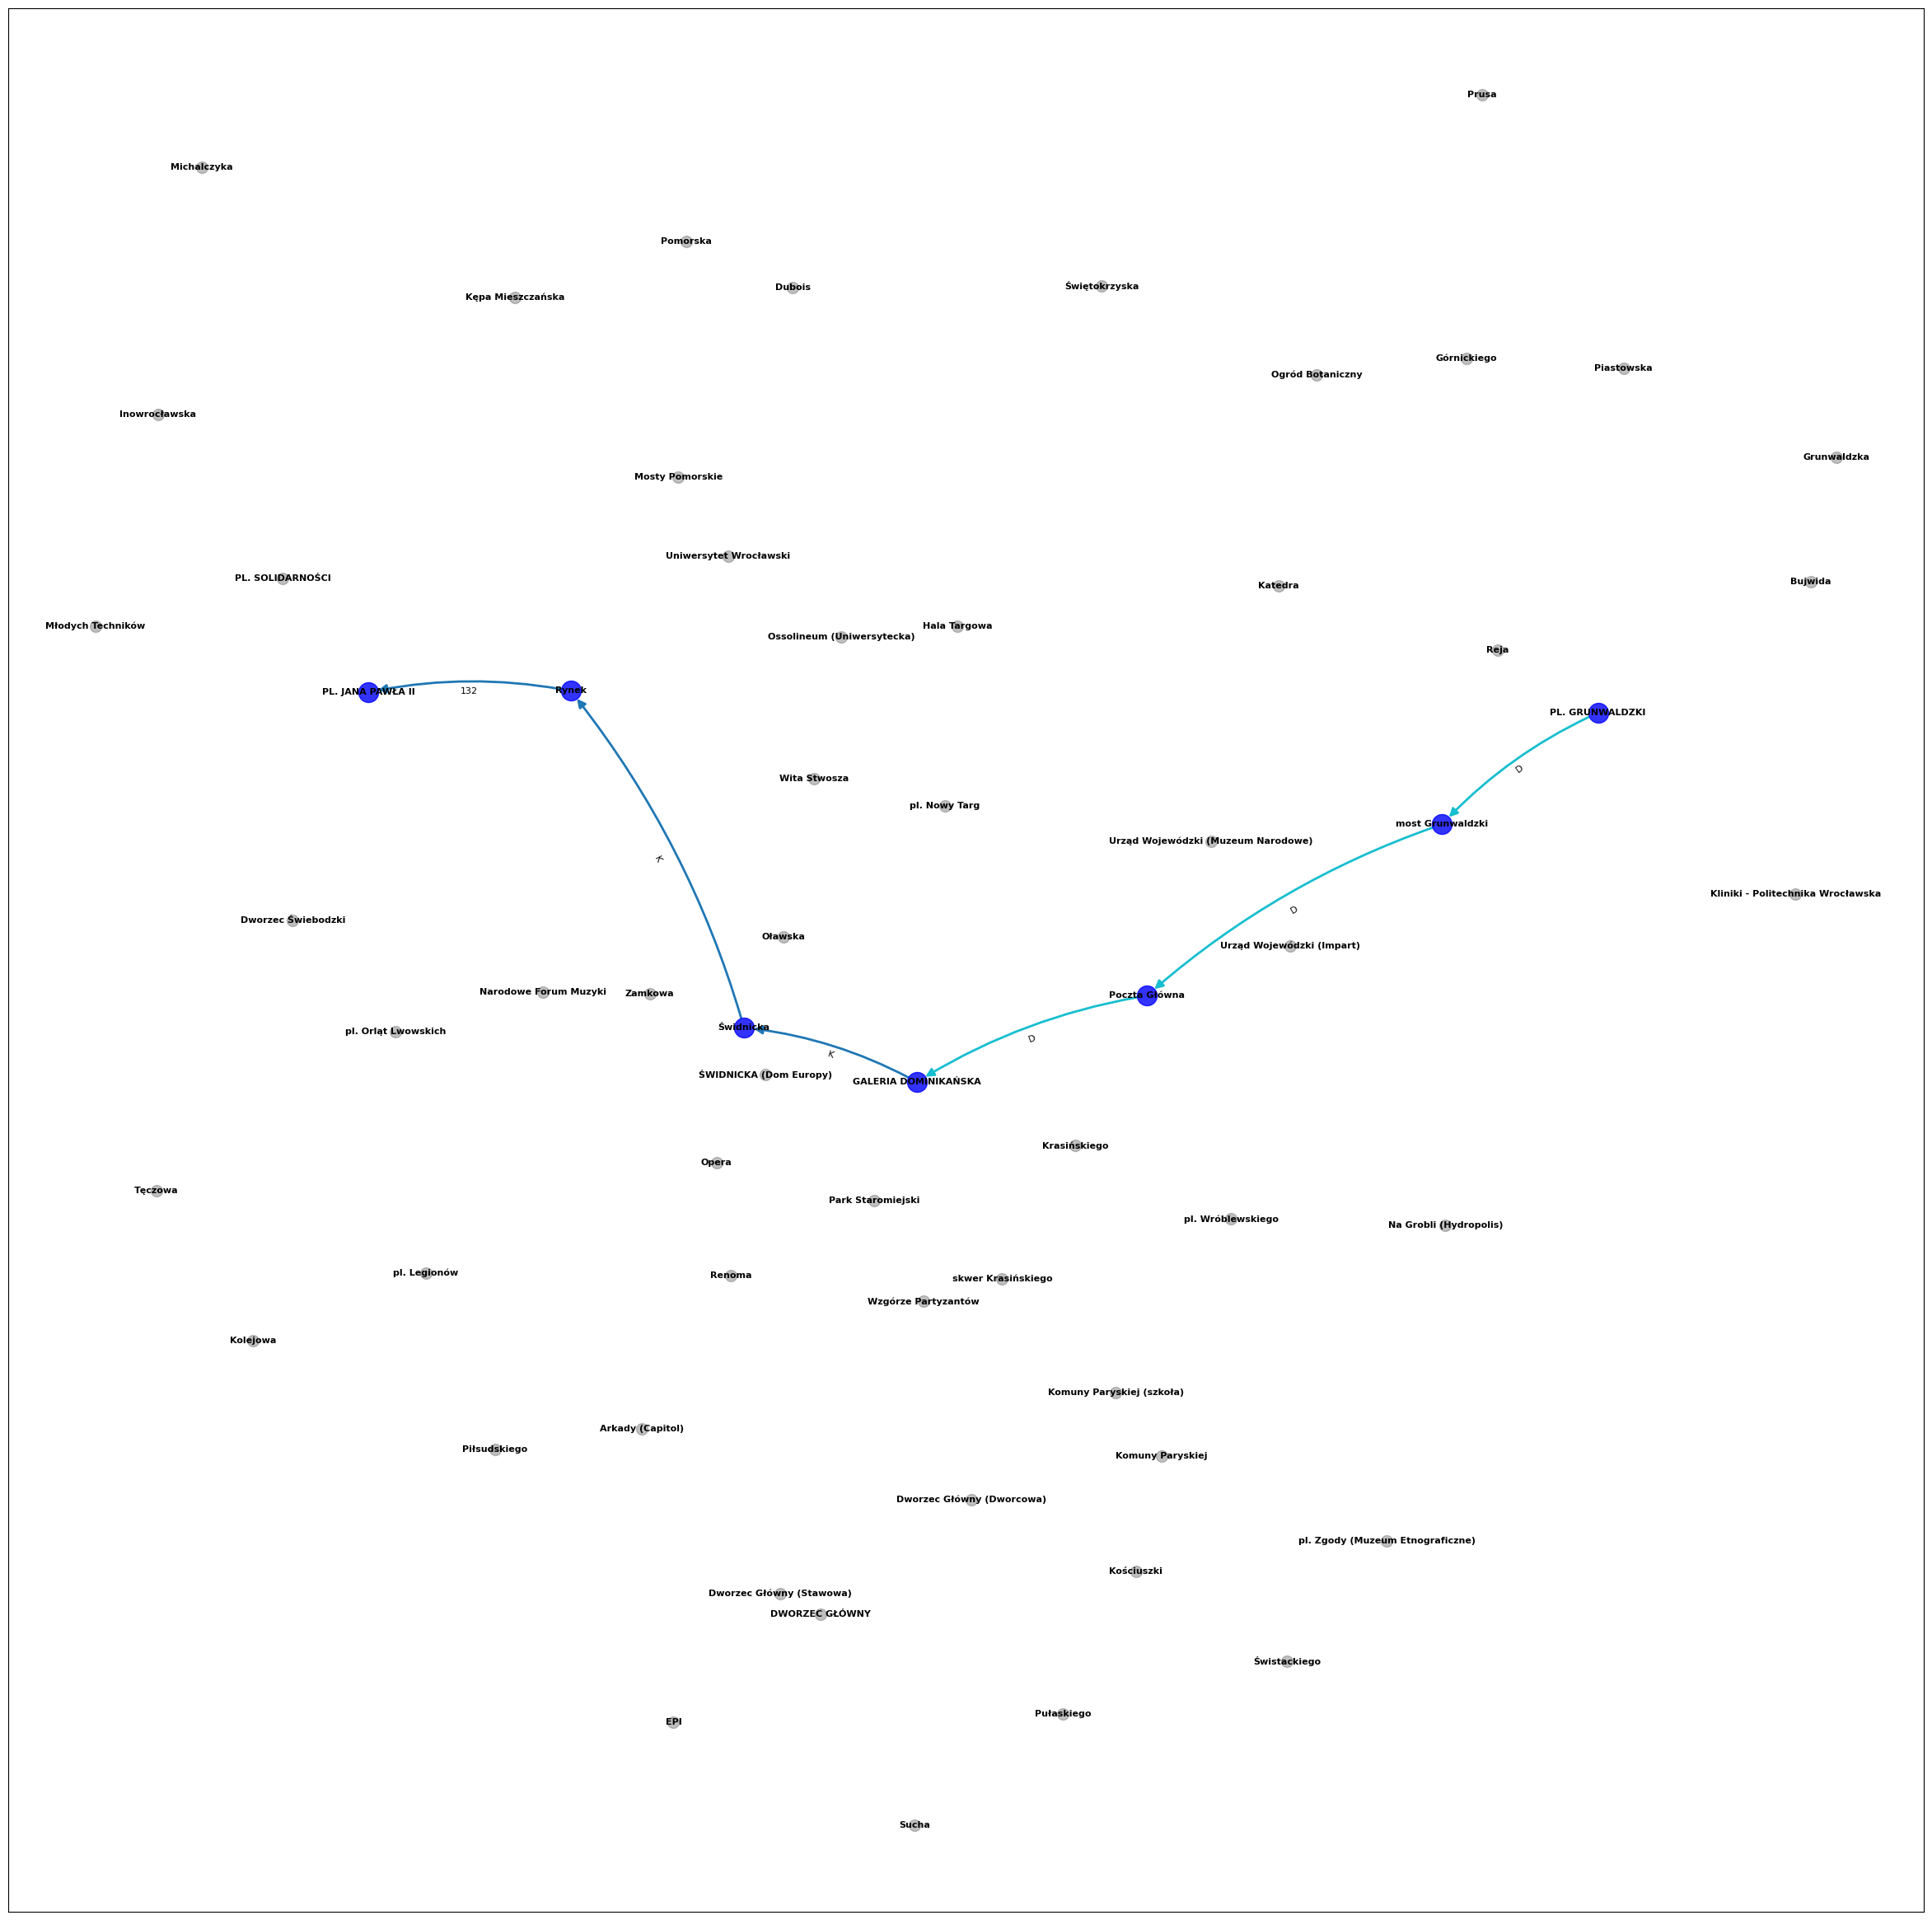

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_optimal_route(stop_graph, route_result, figsize=(30, 30), output_file=None):
    G = nx.DiGraph()
    
    if route_result and 'route' in route_result:
        route_connections = route_result['route']
        edge_colors = []
        edge_labels = {}
        route_stops = set()
        
        for conn in route_connections:
            start_name = conn.start.name
            end_name = conn.end.name
            
            G.add_edge(start_name, end_name, label=f"Linia {conn.line}")
            edge_labels[(start_name, end_name)] = f"{conn.line}"
            edge_colors.append(f"C{hash(conn.line) % 10}")
            
            route_stops.add(start_name)
            route_stops.add(end_name)
        
        # Dodajemy pobliskie przystanki na podstawie odległości geograficznej
        nearby_stops = set()
        threshold_distance = 0.01  # Próg odległości 
        
        for stop_name in route_stops:
            stop = stop_graph[stop_name]
            for other_name, other_stop in stop_graph.items():
                if other_name not in route_stops:
                    distance = ((stop.lon - other_stop.lon) ** 2 + (stop.lat - other_stop.lat) ** 2) ** 0.5
                    if distance < threshold_distance:
                        nearby_stops.add(other_name)
                        G.add_node(other_name, pos=(other_stop.lon, other_stop.lat))
        
        pos = {stop: (stop_graph[stop].lon, stop_graph[stop].lat) for stop in route_stops.union(nearby_stops)}
        
        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(G, pos, nodelist=route_stops, node_size=300, node_color='blue', alpha=0.8)
        nx.draw_networkx_nodes(G, pos, nodelist=nearby_stops, node_size=100, node_color='gray', alpha=0.5)
        nx.draw_networkx_edges(G, pos, width=2, edge_color=edge_colors, 
                              connectionstyle='arc3,rad=0.1', arrows=True, arrowsize=15)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
        
        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Wykres zapisany do pliku: {output_file}")
        
    return plt

# Przykład użycia:
router = DijkstraRouter(stop_graph)
result = router.find_route("Wilczyce - Sosnowa", "Kołobrzeska", datetime.strptime("07:00:00", "%H:%M:%S"))

# Rysowanie grafu z optymalną trasą
plt_obj = draw_optimal_route(stop_graph, result, output_file="optymalna_trasa.png")
plt_obj.show()

# Zad 2

## Tabu search

In [ ]:
from collections import deque

class TSPSolver:
    def __init__(self, stop_graph):
        self.stop_graph = stop_graph
        self.time_router = AStarRouter  (stop_graph, hybrid_penalty_function)  
        self.transfer_router = AstarRouterForTransfers(stop_graph, hybrid_penalty_function)

    def _validate_stops(self, stops_list):
        #Sprawdzenie, czy wszystkie przystanki istnieją w grafie.
        for stop in stops_list:
            if stop not in self.stop_graph:
                print(f"ERROR: Przystanek {stop} nie istnieje w grafie.")
                return False
        return True

    def _find_route_between_stops(self, start_stop, end_stop, start_time, optimization_type='t'):
        #Znajdź najlepszą trasę między dwoma przystankami.
        if isinstance(start_time, str):
            base_date = datetime(2025, 1, 1)
            time_obj = datetime.strptime(start_time, "%H:%M:%S")
            start_time = base_date.replace(hour=time_obj.hour, minute=time_obj.minute, second=time_obj.second)
        
        # Wybierz odpowiedni router w zależności od typu optymalizacji
        router = self.time_router if optimization_type == 't' else self.transfer_router
        
        # Znajdź trasę za pomocą odpowiedniego routera
        return router.find_route(start_stop, end_stop, start_time)

    def _calculate_solution_cost(self, solution, start_time, optimization_type='t'):
        #Oblicz koszt rozwiązania (sekwencji przystanków).
        total_time = 0
        total_transfers = 0
        current_time = start_time
        previous_stop = solution[0]
        
        for next_stop in solution[1:]:
            route = self._find_route_between_stops(previous_stop, next_stop, current_time, optimization_type)
            
            if route is None:
                # Jeśli nie znaleziono trasy, zwróć maksymalny koszt
                return float('inf'), float('inf')
            
            # Handling different types of total_cost
            if isinstance(route['total_cost'], str):
                # Handle string format "Xh Ymin"
                route_time_parts = route['total_cost'].split()
                hours = int(route_time_parts[0].replace('h', ''))
                minutes = int(route_time_parts[1].replace('min', ''))
                route_time_minutes = hours * 60 + minutes
            elif isinstance(route['total_cost'], (int, float)):
                # Handle numeric format (assuming minutes)
                route_time_minutes = route['total_cost']
            else:
                # Unexpected format
                print(f"Unexpected total_cost format: {route['total_cost']}")
                return float('inf'), float('inf')
            
            total_time += route_time_minutes
            total_transfers += route['transfers']
            
            # Aktualizuj czas dla następnego odcinka
            last_connection = route['route'][-1]
            current_time = last_connection.arrival_time
            previous_stop = next_stop
        
        # Dodaj trasę powrotną do punktu początkowego
        return_route = self._find_route_between_stops(solution[-1], solution[0], current_time, optimization_type)
        
        if return_route is None:
            return float('inf'), float('inf')
        
        # Dodaj koszt trasy powrotnej
        if isinstance(return_route['total_cost'], str):
            route_time_parts = return_route['total_cost'].split()
            hours = int(route_time_parts[0].replace('h', ''))
            minutes = int(route_time_parts[1].replace('min', ''))
            route_time_minutes = hours * 60 + minutes
        elif isinstance(return_route['total_cost'], (int, float)):
            route_time_minutes = return_route['total_cost']
        else:
            print(f"Unexpected total_cost format: {return_route['total_cost']}")
            return float('inf'), float('inf')
        
        total_time += route_time_minutes
        total_transfers += return_route['transfers']
        
        return total_time, total_transfers

    def _get_solution_cost(self, solution, start_time, optimization_type):
        #Pobierz koszt rozwiązania na podstawie typu optymalizacji.
        time_cost, transfers_cost = self._calculate_solution_cost(solution, start_time, optimization_type)
        return time_cost if optimization_type == 't' else transfers_cost

    def _generate_neighbors(self, solution, neighborhood_strategy='swap'):
        #Generuj sąsiednie rozwiązania na podstawie wybranej strategii.
        neighbors = []
        n = len(solution)
        
        # Zawsze zachowaj pierwszy przystanek (punkt startowy) jako stały
        if neighborhood_strategy == 'swap':
            # Strategia zamiany: wymiana pozycji dwóch przystanków
            for i in range(1, n):
                for j in range(i+1, n):
                    neighbor = solution.copy()
                    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                    neighbors.append(neighbor)
        
        elif neighborhood_strategy == '2-opt':
            # Strategia 2-opt: odwrócenie segmentu trasy
            for i in range(1, n-1):
                for j in range(i+1, n):
                    neighbor = solution.copy()
                    # Odwróć segment między i a j
                    neighbor[i:j+1] = neighbor[i:j+1][::-1]
                    neighbors.append(neighbor)
        
        elif neighborhood_strategy == 'insert':
            # Strategia wstawiania: przeniesienie przystanku na inną pozycję
            for i in range(1, n):
                for j in range(1, n):
                    if i != j:
                        neighbor = solution.copy()
                        stop = neighbor.pop(i)
                        neighbor.insert(j, stop)
                        neighbors.append(neighbor)
        
        elif neighborhood_strategy == 'hybrid':
            # Mieszanka strategii dla dywersyfikacji
            swap_neighbors = self._generate_neighbors(solution, 'swap')
            opt_neighbors = self._generate_neighbors(solution, '2-opt')
            insert_neighbors = self._generate_neighbors(solution, 'insert')
            
            # Losowo wybierz sąsiadów z każdej strategii
            neighbors.extend(random.sample(swap_neighbors, min(5, len(swap_neighbors))))
            neighbors.extend(random.sample(opt_neighbors, min(5, len(opt_neighbors))))
            neighbors.extend(random.sample(insert_neighbors, min(5, len(insert_neighbors))))
        
        elif neighborhood_strategy == 'adaptive':
            # Adaptacyjne próbkowanie w zależności od rozmiaru rozwiązania
            if n <= 5:
                # Dla małych problemów, użyj wszystkich sąsiadów
                neighbors = self._generate_neighbors(solution, 'swap')
                neighbors.extend(self._generate_neighbors(solution, '2-opt'))
            else:
                # Dla większych problemów, użyj losowej podgrupy
                subset_size = max(10, n)  # Co najmniej 10 sąsiadów
                
                # Generuj różne typy i wybieraj z nich próbki
                swap_neighbors = self._generate_neighbors(solution, 'swap')
                opt_neighbors = self._generate_neighbors(solution, '2-opt')
                
                if len(swap_neighbors) > 0:
                    neighbors.extend(random.sample(swap_neighbors, min(subset_size // 2, len(swap_neighbors))))
                if len(opt_neighbors) > 0:
                    neighbors.extend(random.sample(opt_neighbors, min(subset_size // 2, len(opt_neighbors))))
        
        return neighbors

    def _initialize_search_structures(self, start_stop, stops_to_visit):
        #Inicjalizacja struktur danych potrzebnych do przeszukiwania.
        # Utwórz kompletną listę przystanków, w tym przystanek początkowy
        all_stops = [start_stop] + stops_to_visit
        
        # Inicjalizacja obecnego rozwiązania (zaczynając od przystanków w podanej kolejności)
        current_solution = all_stops.copy()
        
        return all_stops, current_solution

    def _reconstruct_full_route(self, best_solution, start_time, optimization_type):
        #Odtwarzanie pełnej trasy na podstawie najlepszego rozwiązania.
        full_route = []
        total_time = 0
        total_transfers = 0
        current_time_obj = start_time
        previous_stop = best_solution[0]
        
        for next_stop in best_solution[1:] + [best_solution[0]]:  # Dodaj przystanek początkowy na końcu, aby zakończyć cykl
            route_segment = self._find_route_between_stops(previous_stop, next_stop, current_time_obj, optimization_type)
            
            if route_segment:
                full_route.extend(route_segment['route'])
                
                # Aktualizuj liczniki i czas - obsługa różnych formatów total_cost
                if isinstance(route_segment['total_cost'], str):
                    route_time_parts = route_segment['total_cost'].split()
                    hours = int(route_time_parts[0].replace('h', ''))
                    minutes = int(route_time_parts[1].replace('min', ''))
                    route_time_minutes = hours * 60 + minutes
                elif isinstance(route_segment['total_cost'], (int, float)):
                    route_time_minutes = route_segment['total_cost']
                else:
                    print(f"Unexpected total_cost format: {route_segment['total_cost']}")
                    route_time_minutes = 0
                
                total_time += route_time_minutes
                total_transfers += route_segment['transfers']
                
                # Aktualizuj czas bieżący dla następnego odcinka
                if route_segment['route']:
                    current_time_obj = route_segment['route'][-1].arrival_time
                
                previous_stop = next_stop
        
        # Oblicz całkowite metryki
        hours = total_time // 60
        minutes = total_time % 60
        total_cost = f"{int(hours)}h {int(minutes)}min"
        
        return full_route, total_cost, total_transfers

    def tabu_search(self, start_stop, stops_to_visit, start_time, optimization_type='t', 
                    max_iterations=15, tabu_size=None, aspiration=False, sampling_strategy='swap'):
        if not self._validate_stops([start_stop] + stops_to_visit):
            return None
            
        start_measure = time.time()
        
        # Inicjalizacja struktur wyszukiwania
        all_stops, current_solution = self._initialize_search_structures(start_stop, stops_to_visit)
        
        # Ustaw rozmiar tabu na podstawie rozmiaru problemu, jeśli nie określono
        if tabu_size is None:
            tabu_size = len(stops_to_visit)
        
        # Inicjalizacja najlepszego rozwiązania
        best_solution = current_solution.copy()
        best_cost = self._get_solution_cost(current_solution, start_time, optimization_type)
        
        # Inicjalizacja listy tabu jako deque dla efektywnych operacji FIFO
        tabu_list = deque(maxlen=tabu_size)
        
        # Śledzenie iteracji bez poprawy
        no_improvement_count = 0
        diversification_threshold = max(10, len(stops_to_visit) * 2)
        
        # Główna pętla algorytmu
        for iteration in range(max_iterations):
            # Generowanie sąsiadów
            neighbors = self._generate_neighbors(current_solution, sampling_strategy)
            
            # Znalezienie najlepszego sąsiada niebędącego tabu
            best_neighbor = None
            best_neighbor_cost = float('inf')
            
            for neighbor in neighbors:
                # Sprawdzenie, czy ruch jest tabu
                move_is_tabu = str(neighbor) in tabu_list
                
                # Obliczenie kosztu
                neighbor_cost = self._get_solution_cost(neighbor, start_time, optimization_type)
                
                # Sprawdzenie kryterium aspiracji: zaakceptuj ruch tabu, jeśli jest lepszy niż najlepsze rozwiązanie
                if aspiration and move_is_tabu and neighbor_cost < best_cost:
                    move_is_tabu = False
                
                # Aktualizacja najlepszego sąsiada, jeśli nie jest tabu lub spełnia aspirację
                if not move_is_tabu and neighbor_cost < best_neighbor_cost:
                    best_neighbor = neighbor
                    best_neighbor_cost = neighbor_cost
            
            # Jeśli nie znaleziono sąsiada niebędącego tabu, przerwij
            if best_neighbor is None:
                break
            
            # Aktualizacja bieżącego rozwiązania
            current_solution = best_neighbor
            
            # Dodanie do listy tabu
            tabu_list.append(str(current_solution))
            
            # Aktualizacja najlepszego rozwiązania, jeśli uległo poprawie
            if best_neighbor_cost < best_cost:
                best_solution = current_solution.copy()
                best_cost = best_neighbor_cost
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            # Strategia dywersyfikacji: jeśli brak poprawy przez pewien czas, zaburz rozwiązanie
            if no_improvement_count >= diversification_threshold:
                # Wykonaj losową permutację na niestałej części rozwiązania
                shuffled_part = current_solution[1:]
                random.shuffle(shuffled_part)
                current_solution = [current_solution[0]] + shuffled_part
                no_improvement_count = 0
        
        end_measure = time.time()
        
        # Odtwarzanie pełnych szczegółów trasy
        full_route, total_cost, total_transfers = self._reconstruct_full_route(
            best_solution, start_time, optimization_type
        )
        
        # Zwróć szczegóły trasy
        return {
            'route': full_route,
            'total_cost': total_cost,
            'calculation_time': end_measure - start_measure,
            'transfers': total_transfers,
            'best_solution': best_solution
        }


## Porównanie Tabu Search (klasyczego, z adaptacyjna listą tabu, z aspiracją, z adaptacyjnym próbkowaniem)

In [34]:
def find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, optimization_type,
                         tabu_size=None, aspiration=False, sampling_strategy='swap', strategy_name=""):
    """Pomocnicza funkcja do wyszukiwania i wyświetlania trasy."""
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    
    print(f"\n===== STRATEGIA: {strategy_name} =====")
    
    result = tsp_solver.tabu_search(
        start_stop, 
        stops_to_visit, 
        start_time, 
        optimization_type=optimization_type,
        tabu_size=tabu_size,
        aspiration=aspiration,
        sampling_strategy=sampling_strategy
    )
    
    if result:
        print(f"Całkowity czas: {result['total_cost']}")
        print(f"Liczba przesiadek: {result['transfers']}")
        print(f"Czas obliczeń: {result['calculation_time']:.4f} sekund")
        
        print("\nHarmonogram przejazdu (tylko przystanki początkowe i końcowe dla każdej linii):")
        current_line = None
        start_connection = None
        
        for i, connection in enumerate(result['route']):
            # Gdy zmienia się linia lub to jest ostatnie połączenie
            if current_line != connection.line or i == len(result['route']) - 1:
                # Wyświetl poprzednią linię jeśli istnieje
                if current_line is not None:
                    # Jeśli to ostatnie połączenie i linia się nie zmieniła
                    end_connection = connection if current_line == connection.line else result['route'][i-1]
                    
                    print(f"Linia: {current_line}, "
                          f"Z: {start_connection.start.name} o {start_connection.departure_time.strftime('%H:%M:%S')}, "
                          f"Do: {end_connection.end.name} o {end_connection.arrival_time.strftime('%H:%M:%S')}")
                
                # Zapisz nowe połączenie początkowe
                current_line = connection.line
                start_connection = connection
        
        print("\n" + "-" * 50)  # Separator między wynikami
        
        return result
    else:
        print("Nie znaleziono trasy.")
        return None


# Wczytaj dane wejściowe
start_stop = "PL. GRUNWALDZKI" 
stops_to_visit = ["PL. JANA PAWŁA II", "C.H. Korona", "Kołobrzeska", "Husarska", "Psie Pole", "Bezpieczna"]
optimization_type = 't'
start_time_str = '7:00:00'  

# Utwórz instancję routera za pomocą istniejącej klasy DijkstraRouter
router = AStarRouter(stop_graph, heuristic_function=hybrid_penalty_function)

# Utwórz solver TSP
tsp_solver = TSPSolver(stop_graph)

# Znajdź optymalną trasę i wyświetl dla wszystkich wariantów
# Podstawowe rozwiązanie Tabu Search
result_a = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, 
                                optimization_type, strategy_name="Podstawowe Tabu Search")

# Adaptacja rozmiaru tabu na podstawie długości listy
adaptive_tabu_size = len(stops_to_visit) * 2 if len(stops_to_visit) > 3 else 5
result_b = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, 
                                optimization_type, tabu_size=adaptive_tabu_size, 
                                strategy_name=f"Adaptacyjny rozmiar tabu ({adaptive_tabu_size})")

# Kryterium aspiracji
result_c = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, 
                                optimization_type, aspiration=True, 
                                strategy_name="Kryterium aspiracji")

# Zaawansowana strategia próbkowania sąsiedztwa
result_d = find_and_print_route(tsp_solver, start_stop, stops_to_visit, start_time_str, 
                                optimization_type, sampling_strategy='adaptive', 
                                strategy_name="Adaptacyjne próbkowanie sąsiedztwa")

# Określ najlepszy wynik dla podsumowania
results = [r for r in [result_a, result_b, result_c, result_d] if r is not None]
if results:
    best_result = min(results, 
                    key=lambda x: x['transfers'] if optimization_type == 't' else 
                                int(x['total_cost'].split('h')[0])*60 + int(x['total_cost'].split(' ')[1].replace('min','')))
    
    print("\n===== PODSUMOWANIE =====")
    print("Najlepszy wynik uzyskano dla strategii:")
    
    if best_result == result_a:
        print("PODSTAWOWE TABU SEARCH")
    elif best_result == result_b:
        print(f"ADAPTACYJNY ROZMIAR TABU ({adaptive_tabu_size})")
    elif best_result == result_c:
        print("KRYTERIUM ASPIRACJI")
    elif best_result == result_d:
        print("ADAPTACYJNE PRÓBKOWANIE SĄSIEDZTWA")
        
    print(f"Całkowity czas: {best_result['total_cost']}")
    print(f"Liczba przesiadek: {best_result['transfers']}")
    print(f"Czas obliczeń: {best_result['calculation_time']:.4f} sekund")
else:
    print("Nie znaleziono żadnej trasy.")




===== STRATEGIA: Podstawowe Tabu Search =====
Całkowity czas: 2h 54min
Liczba przesiadek: 14
Czas obliczeń: 63.5787 sekund

Harmonogram przejazdu (tylko przystanki początkowe i końcowe dla każdej linii):
Linia: D, Z: PL. GRUNWALDZKI o 07:01:00, Do: GALERIA DOMINIKAŃSKA o 07:06:00
Linia: K, Z: GALERIA DOMINIKAŃSKA o 07:07:00, Do: Rynek o 07:11:00
Linia: 132, Z: Rynek o 07:14:00, Do: PL. JANA PAWŁA II o 07:16:00
Linia: 144, Z: PL. JANA PAWŁA II o 07:16:00, Do: pl. Legionów o 07:20:00
Linia: 4, Z: pl. Legionów o 07:21:00, Do: Grabiszyńska o 07:23:00
Linia: 127, Z: Grabiszyńska o 07:25:00, Do: Hallera o 07:33:00
Linia: 7, Z: Hallera o 07:34:00, Do: Przyjaźni o 07:42:00
Linia: 113, Z: Przyjaźni o 07:45:00, Do: rondo Św. Ojca Pio o 07:49:00
Linia: 144, Z: rondo Św. Ojca Pio o 07:56:00, Do: Gajowicka o 08:09:00
Linia: 14, Z: Gajowicka o 08:13:00, Do: FAT o 08:19:00
Linia: 134, Z: FAT o 08:21:00, Do: Strzegomska (krzyżówka) o 08:29:00
Linia: 107, Z: Strzegomska (krzyżówka) o 08:30:00, Do: Koł

## Porównanie próbkowania sąsiedztwa w algorytmie Tabu Search


Testowanie strategii: swap
Uruchomienie 1: Czas 57.5338s, Koszt 2h 54min, Przesiadki 14
Uruchomienie 2: Czas 64.2940s, Koszt 2h 54min, Przesiadki 14
Uruchomienie 3: Czas 61.0628s, Koszt 2h 54min, Przesiadki 14

Testowanie strategii: 2-opt
Uruchomienie 1: Czas 58.3124s, Koszt 2h 54min, Przesiadki 14
Uruchomienie 2: Czas 58.3747s, Koszt 2h 54min, Przesiadki 14
Uruchomienie 3: Czas 57.8571s, Koszt 2h 54min, Przesiadki 14

Testowanie strategii: insert
Uruchomienie 1: Czas 125.6377s, Koszt 2h 57min, Przesiadki 14
Uruchomienie 2: Czas 126.1645s, Koszt 2h 57min, Przesiadki 14
Uruchomienie 3: Czas 127.3581s, Koszt 2h 57min, Przesiadki 14

Testowanie strategii: hybrid
Uruchomienie 1: Czas 60.0578s, Koszt 2h 54min, Przesiadki 14
Uruchomienie 2: Czas 63.2443s, Koszt 3h 6min, Przesiadki 12
Uruchomienie 3: Czas 60.2378s, Koszt 2h 54min, Przesiadki 14

Testowanie strategii: adaptive
Uruchomienie 1: Czas 41.8195s, Koszt 2h 57min, Przesiadki 14
Uruchomienie 2: Czas 40.7661s, Koszt 2h 54min, Przesiadk

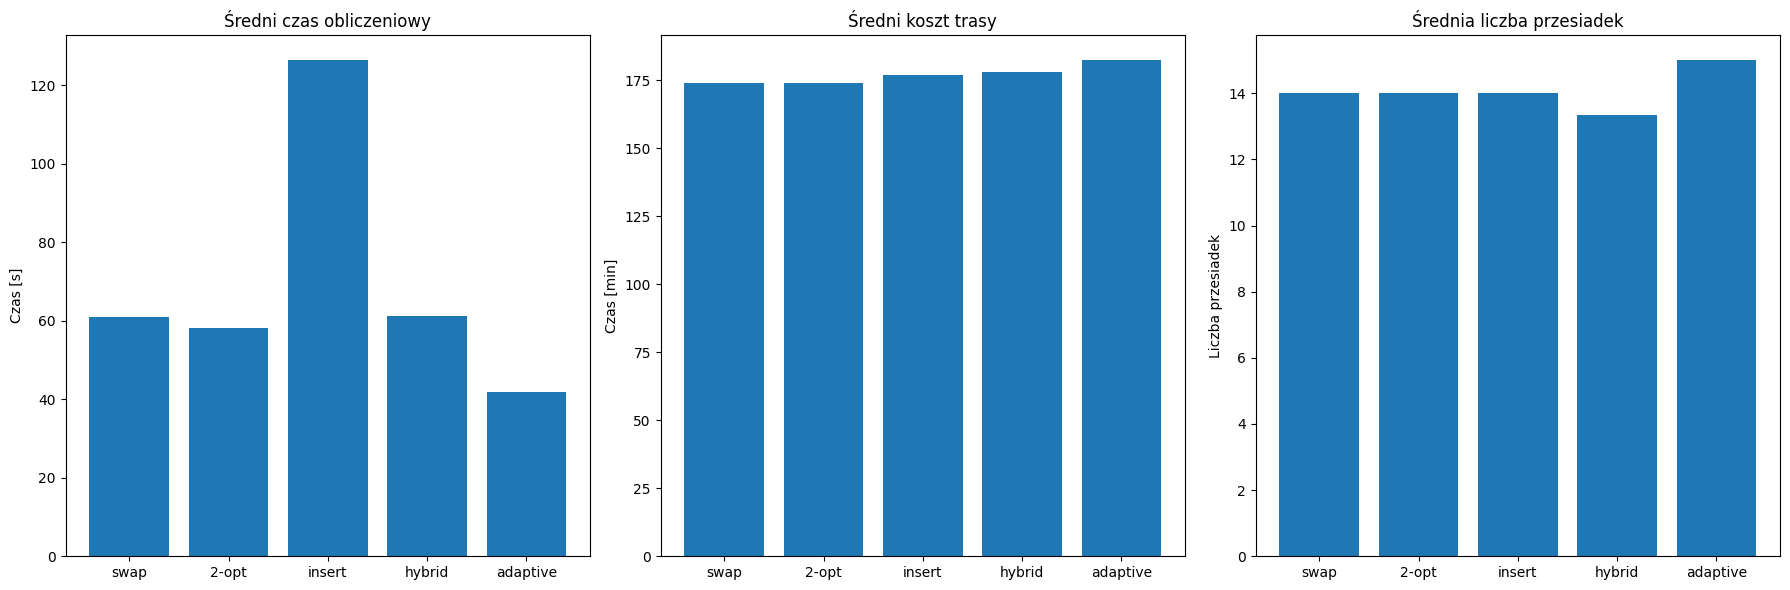


Najlepsza strategia pod względem czasu obliczeniowego: adaptive
Najlepsza strategia pod względem kosztu trasy: swap
Najlepsza strategia pod względem liczby przesiadek: hybrid


In [36]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

def compare_neighborhood_strategies(tsp_solver, start_stop, stops_to_visit, start_time_str, optimization_type):
    # Konwersja czasu rozpoczęcia
    from datetime import datetime
    start_time = datetime.strptime(start_time_str, "%H:%M:%S")
    
    # Strategie do porównania
    strategies = ['swap', '2-opt', 'insert', 'hybrid', 'adaptive']
    
    # Przechowywanie wyników
    results = []
    
    # Dla każdej strategii wykonaj określoną liczbę uruchomień
    num_runs = 3
    for strategy in strategies:
        strategy_times = []
        strategy_costs = []
        strategy_transfers = []
        
        print(f"\nTestowanie strategii: {strategy}")
        
        for run in range(num_runs):
            # Stwórz kopię solvera, aby zapewnić niezależne uruchomienia
            solver_copy = deepcopy(tsp_solver)
            
            # Uruchom algorytm z wybraną strategią
            start_time_measure = time.time()
            result = solver_copy.tabu_search(
                start_stop, 
                stops_to_visit, 
                start_time, 
                optimization_type=optimization_type,
                max_iterations=15,
                aspiration=True,
                sampling_strategy=strategy
            )
            end_time_measure = time.time()
            
            # Obliczenie całkowitego kosztu w minutach
            if result:
                total_cost_parts = result['total_cost'].split()
                hours = int(total_cost_parts[0].replace('h', ''))
                minutes = int(total_cost_parts[1].replace('min', ''))
                total_cost_minutes = hours * 60 + minutes
                
                # Zapisywanie wyników
                strategy_times.append(end_time_measure - start_time_measure)
                strategy_costs.append(total_cost_minutes)
                strategy_transfers.append(result['transfers'])
                
                print(f"Uruchomienie {run+1}: Czas {end_time_measure - start_time_measure:.4f}s, "
                      f"Koszt {result['total_cost']}, Przesiadki {result['transfers']}")
            else:
                print(f"Uruchomienie {run+1}: Nie znaleziono trasy")
        
        # Obliczanie średnich wyników
        if strategy_times:
            avg_time = sum(strategy_times) / len(strategy_times)
            avg_cost = sum(strategy_costs) / len(strategy_costs)
            avg_transfers = sum(strategy_transfers) / len(strategy_transfers)
            
            # Dodanie wyników do listy
            results.append({
                'Strategia': strategy,
                'Średni czas obliczeniowy (s)': avg_time,
                'Średni koszt trasy (min)': avg_cost,
                'Średnia liczba przesiadek': avg_transfers
            })
    
    # Tworzenie DataFrame z wynikami
    results_df = pd.DataFrame(results)
    
    # Wyświetlanie wyników
    print("\nPodsumowanie wyników:")
    print(results_df)
    
    # Wizualizacja wyników
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Czas obliczeniowy
    ax1.bar(results_df['Strategia'], results_df['Średni czas obliczeniowy (s)'])
    ax1.set_ylabel('Czas [s]')
    ax1.set_title('Średni czas obliczeniowy')
    
    # Koszt trasy
    ax2.bar(results_df['Strategia'], results_df['Średni koszt trasy (min)'])
    ax2.set_ylabel('Czas [min]')
    ax2.set_title('Średni koszt trasy')
    
    # Liczba przesiadek
    ax3.bar(results_df['Strategia'], results_df['Średnia liczba przesiadek'])
    ax3.set_ylabel('Liczba przesiadek')
    ax3.set_title('Średnia liczba przesiadek')
    
    plt.tight_layout()
    plt.savefig('porównanie_strategii.png')
    plt.show()
    
    return results_df




# Przykładowe dane wejściowe
start_stop = "PL. GRUNWALDZKI"
stops_to_visit = ["PL. JANA PAWŁA II", "C.H. Korona", "Kołobrzeska", "Husarska", "Psie Pole", "Bezpieczna"]
optimization_type = 't'
start_time_str = '7:00:00'

# Utwórz instancję routera (załóżmy, że AStarRouter i stop_graph są już zdefiniowane)
router = AStarRouter(stop_graph, heuristic_function=hybrid_penalty_function)

# Utwórz solver TSP
tsp_solver = TSPSolver(stop_graph)

# Przeprowadź porównanie
results = compare_neighborhood_strategies(
    tsp_solver, start_stop, stops_to_visit, start_time_str, optimization_type
)

# Zapisz wyniki do pliku CSV
results.to_csv('wyniki_porównania_strategii.csv', index=False)

# Zidentyfikuj najlepszą strategię pod względem czasu obliczeniowego
best_time_strategy = results.loc[results['Średni czas obliczeniowy (s)'].idxmin(), 'Strategia']

# Zidentyfikuj najlepszą strategię pod względem kosztu trasy
best_cost_strategy = results.loc[results['Średni koszt trasy (min)'].idxmin(), 'Strategia']

# Zidentyfikuj najlepszą strategię pod względem liczby przesiadek
best_transfers_strategy = results.loc[results['Średnia liczba przesiadek'].idxmin(), 'Strategia']

print(f"\nNajlepsza strategia pod względem czasu obliczeniowego: {best_time_strategy}")
print(f"Najlepsza strategia pod względem kosztu trasy: {best_cost_strategy}")
print(f"Najlepsza strategia pod względem liczby przesiadek: {best_transfers_strategy}")

